In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import itertools
from itertools import product
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import sys
%matplotlib inline

In [2]:
alldata = pd.read_csv('train.csv', header=0, parse_dates=True, index_col=2)

In [3]:
df = alldata[(alldata['Store']==1) & (alldata['Dept']==1)][['Weekly_Sales']]

In [4]:
df.head()

,Weekly_Sales
Date,
2010-02-05,24924.50
2010-02-12,46039.49
2010-02-19,41595.55
2010-02-26,19403.54
2010-03-05,21827.90


In [5]:
y = df['Weekly_Sales']

In [6]:
type(y)

pandas.core.series.Series

Text(0,0.5,'Weekly Sales')

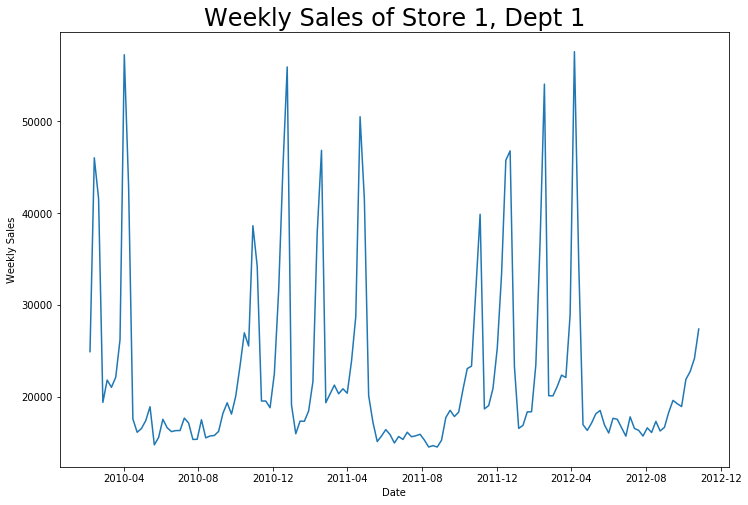

In [7]:
# simple line plot
plt.figure(figsize=(12,8))
plt.plot(df)
plt.title('Weekly Sales of Store 1, Dept 1', fontsize=24)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')

In [8]:
# From this plot, we can see that there is seasonality (large spikes around the same months each year)

### Seasonal Decomposition graphs 

In [9]:
## Let's looka the trend, seasonality and residuals by plotting the seasonal decomposition graphs

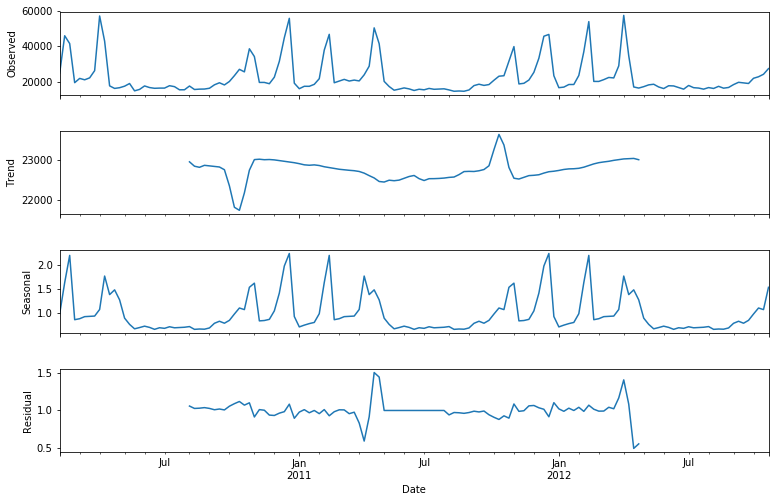

In [10]:
# multiplicative seasonal decomposition

decomp_mul = seasonal_decompose(y, model='multiplicative') #where y = df['Weekly_Sales']
fig = decomp_mul.plot()
fig.set_size_inches(12, 8)

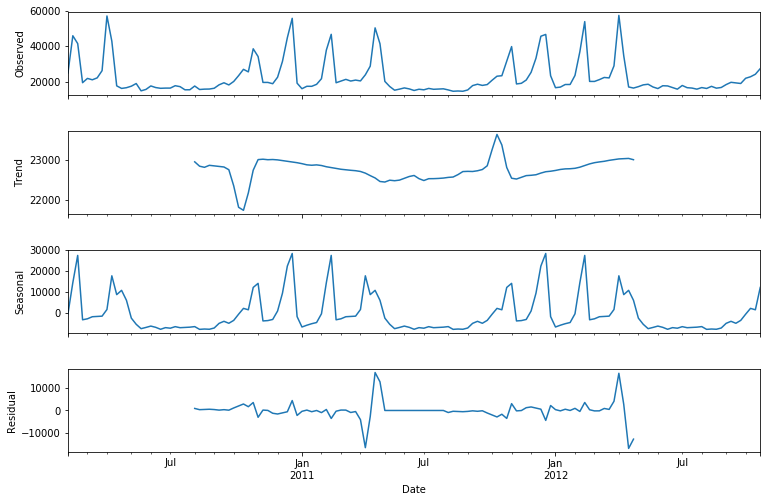

In [11]:
# additive seasonal decomposition

decomp_add = seasonal_decompose(y, model='additive')
fig = decomp_add.plot()
fig.set_size_inches(12, 8)

In [12]:
## Seasonality is seen from the Observed as well the seasonal graph (splikes appearing in intervals).
## There does not seem to be trend in the data, from the trend graph

In [13]:
## Scale is different in additive graphs for Seasonal and residuals.
## Additive decomposition shows high residual values
## So we can say that multiplicative model is preferable.

In [14]:
## Before forecasting models can be applied, the series must be transformed into a stationary time series. 
## This can be done using the Augmented Dickey Fuller test. 

### Augmented Dickey-Fuller Test for Stationarity

In [15]:
from statsmodels.tsa.stattools import adfuller, kpss

In [16]:
# H0: The time series is non-stationary
# Ha: The time series is stationary

In [17]:
## If the test statistic is smaller than the critical value, the NULL hypothesis is rejected

In [18]:
y = df['Weekly_Sales']

In [19]:
#Perform Dickey-Fuller test:
def adf_test(y):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(y, autolag='AIC')
    print('Test Statistic: ','%f' %(dftest[0]))
    print('p-value: ','%f' %(dftest[1]))
    print('#Lags Used: ','%d' %(dftest[2]))
    print('Number of Observations Used: ','%d' %(dftest[3]))
    print('Critical Values:')
    for key,value in dftest[4].items():            
        print('\t%s: %.3f' %(key, value))


In [20]:
adf_test(y)

Results of Dickey-Fuller Test:
Test Statistic:  -2.522164
p-value:  0.110174
#Lags Used:  6
Number of Observations Used:  136
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


In [21]:
## Because the test statistic is above the 5% critical value and the p-value is larger than 0.05 
## the null hypothesis of the Augmented Dickey-Fuller test cannot be rejected, and it 
## can be said that the series is not stationary.

### First Difference

In [22]:
## Take the first difference of y, and then check for statonarity using the ADF test.

In [23]:
# difference time series
y_diff = np.diff(y)

In [24]:
adf_test(y_diff)

Results of Dickey-Fuller Test:
Test Statistic:  -11.044311
p-value:  0.000000
#Lags Used:  5
Number of Observations Used:  136
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


In [25]:
## Because the test statistic is less than the critical values, we can reject the Null hypothesis and conclude that the 
## time series with first difference is stationary

### ARIMA

In [26]:
## We can use the ARIMA (autoregressive integrated moving average) model to fit the time series data 
## in order to predict future points in the series.

In [28]:
## There are three distinct integers (p, d, q) that are used to parametrize ARIMA models.
## These three parameters account for seasonality, trend, and noise in datasets

## p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model.
## d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing.
## q is the moving average part of the model. This allows us to set the error of our model as a 
## linear combination of the error values observed at previous time points in the past.

In [29]:
## Since we have time series with seasonal effects, we can use the seasonal ARIMA,
## which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters, 
## while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. 
## The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

In [32]:
y = df['Weekly_Sales'] ### Question: should we use the y_diff that we calc'ed or original values for fitting the model

In [34]:
y.tail()

Date
2012-09-28    18947.81
2012-10-05    21904.47
2012-10-12    22764.01
2012-10-19    24185.27
2012-10-26    27390.81
Name: Weekly_Sales, dtype: float64

In [35]:
# Split train and test sets
y_train = y[:'2011']
y_test = y['2012':]

In [81]:
y_train['2011'].index
#y_train.tail()

DatetimeIndex(['2011-01-07', '2011-01-14', '2011-01-21', '2011-01-28',
               '2011-02-04', '2011-02-11', '2011-02-18', '2011-02-25',
               '2011-03-04', '2011-03-11', '2011-03-18', '2011-03-25',
               '2011-04-01', '2011-04-08', '2011-04-15', '2011-04-22',
               '2011-04-29', '2011-05-06', '2011-05-13', '2011-05-20',
               '2011-05-27', '2011-06-03', '2011-06-10', '2011-06-17',
               '2011-06-24', '2011-07-01', '2011-07-08', '2011-07-15',
               '2011-07-22', '2011-07-29', '2011-08-05', '2011-08-12',
               '2011-08-19', '2011-08-26', '2011-09-02', '2011-09-09',
               '2011-09-16', '2011-09-23', '2011-09-30', '2011-10-07',
               '2011-10-14', '2011-10-21', '2011-10-28', '2011-11-04',
               '2011-11-11', '2011-11-18', '2011-11-25', '2011-12-02',
               '2011-12-09', '2011-12-16', '2011-12-23', '2011-12-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

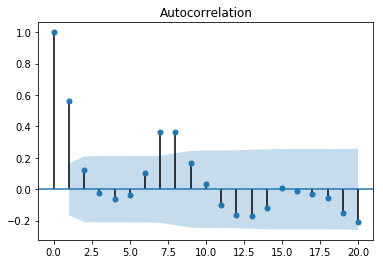

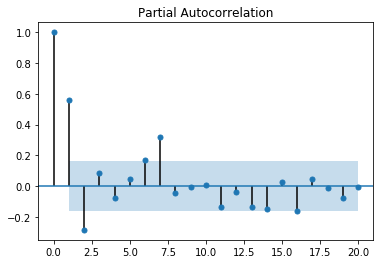

In [55]:
## Plot the ACF and PACF graphs to get an idea of what the p,q parameters should be:

smt.graphics.plot_acf(y, lags=20)
smt.graphics.plot_pacf(y, lags=20);

In [56]:
## From PACF: since the first significant spike in the blue shaded area is at 2 (negative correlation),
## we can say that the p = 2
## From ACF: since the first significant spike iin the blue shaded area is ar 2, we can say that q = 2

## However, we use the range(0,2) to come up with the optimal parameter using grid search

In [60]:
#### Grid Search to find the optimal parameters p,d,q,P,D,Q where s = 52 (weeks)

In [61]:
# Define the p, d and q parameters to take any value between 0 and 2, and 52 weeks for periodicity 's'
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [62]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [63]:
seasonal_pdq

[(0, 0, 0, 52),
 (0, 0, 1, 52),
 (0, 1, 0, 52),
 (0, 1, 1, 52),
 (1, 0, 0, 52),
 (1, 0, 1, 52),
 (1, 1, 0, 52),
 (1, 1, 1, 52)]

In [64]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None
 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
           # print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}52 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))


Best SARIMAX(1, 1, 1)x(0, 1, 0, 52)52 model - AIC:993.7306012242392


In [65]:
## Since (1, 1, 1)x(0, 1, 0, 52) is found to be the best model, we can use that these parameters

In [66]:
model = sm.tsa.statespace.SARIMAX(y_train, order = (1,1,1),seasonal_order = (0, 1, 0, 52),enforce_stationarity=True,
                                                enforce_invertibility=True)

In [67]:
result = model.fit()

In [68]:
print(result.aic)

993.730601224


In [69]:
print(result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       Weekly_Sales   No. Observations:                  100
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 52)   Log Likelihood                -493.865
Date:                            Sat, 27 Jan 2018   AIC                            993.731
Time:                                    16:07:33   BIC                           1001.546
Sample:                                02-05-2010   HQIC                           996.894
                                     - 12-30-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6455      0.128      5.060      0.000       0.395       0.896
ma.L1         -0.9028      0.062   

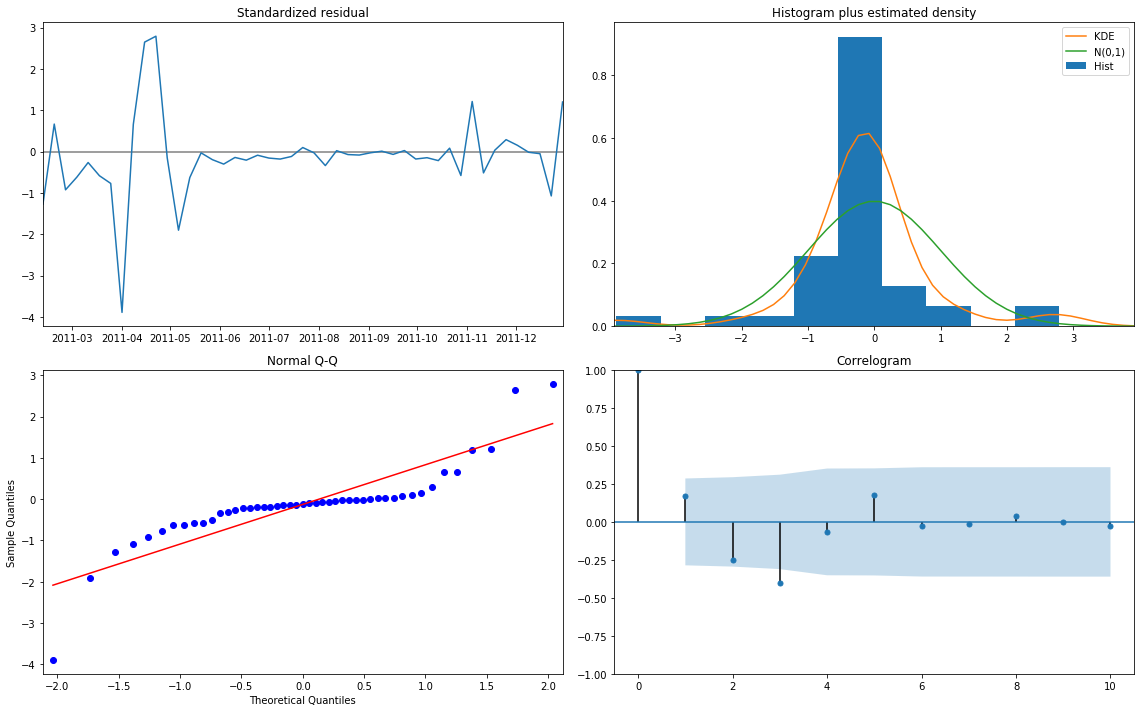

In [74]:
result.plot_diagnostics(figsize=(16,10))
plt.tight_layout()

In [75]:
## The residuals does not display any seasonality or trend behavior. It appears to be white noise
## In the histogram, the green line is the standard normal distribution, and the kde of the time series is 
## plotted in the orange line. 
# Question: Since the orange is also bell shaped with the center 0, and although not overlapping the green line,
## can we say that the time series is normal?
## Correlogram shows that the time series residuals show low correlations with lagged residuals. Although there is 
## one big spike at 2.5

In [85]:
y_train['2011'].index[-1]

Timestamp('2011-12-30 00:00:00')

### One step ahead prediction

In [89]:
## Use the model to forecast for time periods that we already have data for,
## so we can understand how accurate are the forecasts.

In [132]:
## Predict for time period already avaiable in train data
forecast = result.predict(start = y_train['2011'].index[0],end=y_train['2011'].index[-1],dynamic= True) 

In [134]:
## Calculate the CI for predicted data
forecast_ci = result.get_prediction(start = y_train['2011'].index[0],end=y_train['2011'].index[-1],dynamic= True)  

In [133]:
forecast.head()

2011-01-07    21492.282616
2011-01-14    23020.693952
2011-01-21    24007.321749
2011-01-28    24644.214702
2011-02-04    49682.713979
Freq: W-FRI, dtype: float64

In [135]:
forecast_ci.conf_int().head()

,lower Weekly_Sales,upper Weekly_Sales
2011-01-07,3445.506124,39539.059107
2011-01-14,469.432311,45571.955594
2011-01-21,-912.160546,48926.804045
2011-01-28,-1756.186466,51044.615870
2011-02-04,22238.440548,77126.987410


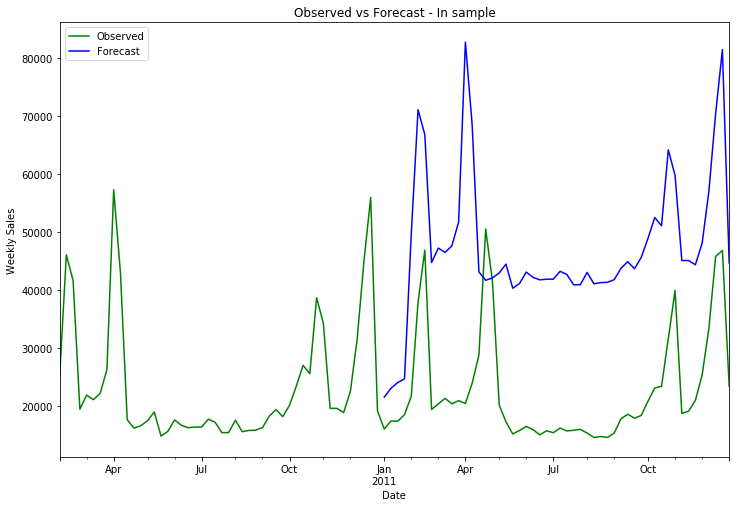

In [136]:
## Plot the y_train (observed) and the predicted (forecast)

y_train.plot(figsize=(12,8),color='green',label='Observed')
forecast.plot(figsize=(12,8),color='blue',label='Forecast')
plt.ylabel('Weekly Sales')
plt.title('Observed vs Forecast - In sample')
plt.legend(loc='best');

In [177]:
y_hat = forecast
y_true = y_train['2011']

In [179]:
y_hat.shape

(52,)

In [138]:
mean_squared_error(y_true, y_hat)

702460202.9798038

In [139]:
mean_absolute_error(y_true, y_hat)

24767.506857789936

### Out of sample prediction

In [185]:
## Predict for 200 weeks, such that it includes the test_df timeframe
forecast_out = result.predict(start = 0,end=200,
                              dynamic=False, full_results=True)

In [186]:
forecast_out.head()

2010-02-05        0.000000
2010-02-12    20891.892906
2010-02-19    38771.436258
2010-02-26    36335.581475
2010-03-05    19608.455259
Freq: W-FRI, dtype: float64

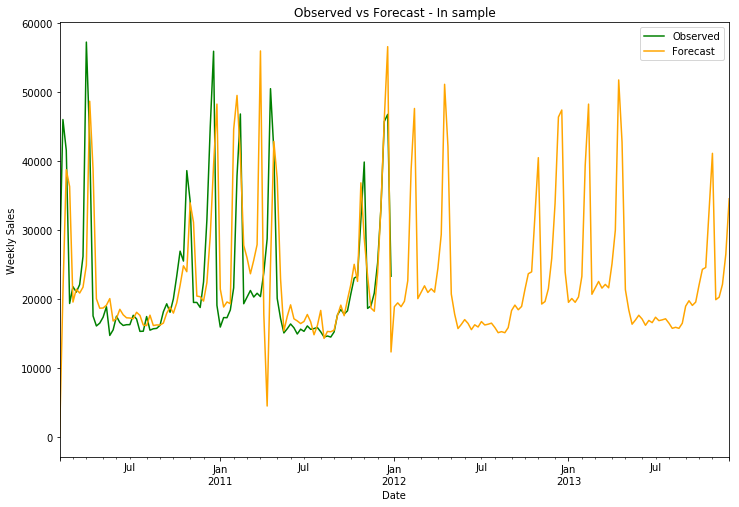

In [187]:
## Plot the y_train (observed) and the predicted (forecast)

y_train.plot(figsize=(12,8),color='green',label='Observed')
forecast_out.plot(figsize=(12,8),color='orange',label='Forecast')
plt.ylabel('Weekly Sales')
plt.title('Observed vs Forecast - In sample')
plt.legend(loc='best');

In [188]:
start = y_train.index[0]
end = y_train.index[-1]
y_hat = forecast_out[start:end]
y_true = y_train

In [191]:
mean_squared_error(y_true, y_hat)

92847062.126731113

In [192]:
mean_absolute_error(y_true, y_hat)

5525.9058034863046